## This code illustrates the fast AI implementation of the unsupervised "biological" learning algorithm from [Unsupervised Learning by Competing Hidden Units](https://doi.org/10.1073/pnas.1820458116) on MNIST data set. 
If you want to learn more about this work you can also check out this [lecture](https://www.youtube.com/watch?v=4lY-oAY0aQU) from MIT's [6.S191 course](http://introtodeeplearning.com/). 

## Imports and Parameters

In [2]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from tensorflow import keras
from tensorflow.keras import layers
import torch
print(torch.cuda.is_available())

True


This cell defines paramaters of the algorithm: 
- `eps0`: initial learning rate that is linearly annealed during training
- `N_hid`: number of hidden units that are displayed as an `Ky` by `Kx` array by the `draw_weights` function defined below
- `mu`: the mean of the gaussian distribution that initializes the weights
- `sigma`: the standard deviation of that gaussian 
- `Nep`: number of epochs
- `N_batch`: size of the minibatch
- `prec`: parameter that controls numerical precision of the weight updates
- `delta`: the strength of the anti-hebbian learning
- `p`: Lebesgue norm of the weights; `k` - ranking parameter. 
- `N_in`: number of input units
- `val_split`: the proportion of validation split

In [3]:
eps0 = 4e-2    # initial learning rate for the unsupervised part
Kx = 10
Ky = 10
hid_disp = Kx*Ky    # number of hidden units that are displayed in Ky by Kx array
N_hid = 1000    # number of hidden units
mu = 0.0
sigma = 1.0
Nep = 1000     # number of epochs
N_batch = 100  # size of the minibatch
prec = 1e-30
delta = 0.4    # Strength of the anti-hebbian learning
p = 2.0        # Lebesgue norm of the weights
k = 2          # ranking parameter, must be integer that is bigger or equal than 2

N_in = 784     # input units
Nc = 10        # number of classes
val_split = 1/6

In [18]:
# Cuda Parameters
use_cuda = torch.cuda.is_available()
torch.cuda.empty_cache()
device = torch.device("cuda" if use_cuda else "cpu")
# device="cpu"

In [19]:
# a utility function to shuffle training and testing samples
def shuffle(xt, yt, xv, yv):
    
    # xt, yt: training samples and labels
    # xv, yv: validation samples and labels
    
    pt = np.random.permutation(len(xt))
    pv = np.random.permutation(len(xv))
    return(xt[pt], yt[pt], xv[pv], yv[pv])

In [20]:
# move data from and to gpu

def detach(tensor):
    try:
        return tensor.cpu().detach().numpy()
    except:
        return tensor
    
def attach(tensor):
    try:
        torch.from_numpy(tensor).float().to(device)
    except:
        return tensor

## Data
Let's load the data from `keras`:
- Use `keras.datasets.mnist.load_data()` to load the 60000 train and 10000 test samples.
- Shuffle them
- Normalize to \[0, 1\] range
- Reshape images to (#samples, 784) and labels to (#samples, 10)
- Split the train part to 50000 train and 10000 validation samples

In [21]:
# Cell derived from this page: https://keras.io/examples/vision/mnist_convnet/

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# reshape to (# samples, 784)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]* x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]* x_test.shape[2])

# shuffle
x_train, y_train, x_test, y_test = shuffle(x_train, y_train, x_test, y_test)

# normalize
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# indices of validation splilt
val_idx = np.random.choice(x_train.shape[0], int(val_split * x_train.shape[0]), replace=False)

#split validation
x_val = x_train[val_idx]
y_val = y_train[val_idx]
x_train = np.delete(x_train, val_idx, axis=0)
y_train = np.delete(y_train, val_idx, axis=0)

# some logging
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, Nc)
y_val = keras.utils.to_categorical(y_val, Nc)
y_test = keras.utils.to_categorical(y_test, Nc)

x_train shape: (50000, 784)
y_train shape: (50000,)
x_val shape: (10000, 784)
y_val shape: (10000,)
50000 train samples
10000 test samples


In [22]:
N_train = x_train.shape[0]
N_val = x_val.shape[0]
N_test = x_test.shape[0]

## Weights visualization
To draw a heatmap of the weights a helper function is created:

In [23]:
def draw_weights(synapses, Kx, Ky, ax=None):
    # synapses: the weights
    Kw = int(np.sqrt(synapses.shape[1]))
    yy=0
    HM=np.zeros((Kw*Ky,Kw*Kx))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*Kw:(y+1)*Kw,x*Kw:(x+1)*Kw]=synapses[yy,:Kw*Kw].reshape(Kw,Kw)
            yy += 1
   
    nc=np.amax(np.absolute(HM))
    
    if ax is not None:
        im = ax.imshow(HM, cmap='bwr', vmin=-nc, vmax = nc)
        fig.colorbar(im, ticks=[np.amin(HM), 0, np.amax(HM)], ax=ax)
        ax.axis('off')
    else:
        plt.clf()
        im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
        fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
        plt.axis('off')
    fig.canvas.draw() 

## Forward pass of the unsupervised part
This is one step of the training and returns the changes that should be applied to the weights in one iteration. 

**Note:** In the testing phase, we don't need to compute `h` or `g` functions, so we just return the input currents.
- Given the inputs and the synapses (weights), compute the input currents `tot_input` = <W.v>
    - This is referred to `I` in the paper.
- If we're in the testing phase, return `tot_input`
- If we're in the training phase, go on to use the rankings in the input currents as proxies for the final `h` and return the changes that should be application 

In [24]:
def forward(inputs, synapses, p, N_hid, N_batch, training=True):
    inputs = torch.transpose(inputs, 0, 1)
    sig = torch.sign(synapses).to(device)
    
    # with p=2, this is equal to <W.v> = I 
    tot_input = torch.mm(sig*torch.abs(synapses).pow(p-1), inputs)
    
    if training == False:
        return torch.transpose(tot_input, 0, 1)
    
    y = torch.argsort(tot_input, dim=0).to(device) # using tot_input (I) as proxy for h
    y1 = torch.zeros((N_hid, N_batch)).to(device)  # g(Q)
    
    y1[y[N_hid-1, :], np.arange(N_batch)] = 1.0    # g(max_activation in I) = 1
    y1[y[N_hid-k], np.arange(N_batch)] = -delta    # g(second max activation) = -0.4
    
    xx = torch.sum(torch.mul(y1, tot_input), 1)    # g(Q) * <W, v>

    ds = torch.matmul(y1, torch.transpose(inputs, 0, 1)) - torch.mul(xx.reshape(xx.shape[0],1).repeat(1, N_in), synapses)
    nc = torch.max(torch.abs(ds))
    return ds, nc

## The unsupervised training of the hidden layer
This cell defines the main code. The external loop runs over epochs `nep`, the internal loop runs over minibatches. For every minibatch the overlap with the data `tot_input` is calculated for each data point and each hidden unit. The sorted strengths of the activations are stored in `y`. The variable `yl` stores the activations of the post synaptic cells - it is denoted by g(Q) in Eq 3 of [Unsupervised Learning by Competing Hidden Units](https://doi.org/10.1073/pnas.1820458116), see also Eq 9 and Eq 10. The variable `ds` is the right hand side of Eq 3. The weights are updated after each minibatch in a way so that the largest update is equal to the learning rate `eps` at that epoch. The weights are displayed by the helper function after each epoch. 

### Note
This will take some time, especially if the hidden layer is big (e.g. N_hid>500). If you want to see a demo, skip to the next cell to load the pre-trained weights.

If you do train the model yourself, make sure to comment the next cell so you don't replace the your trained weights with the pre-trained ones!

## GPU Implementation of the Unsupervised Training

<IPython.core.display.Javascript object>


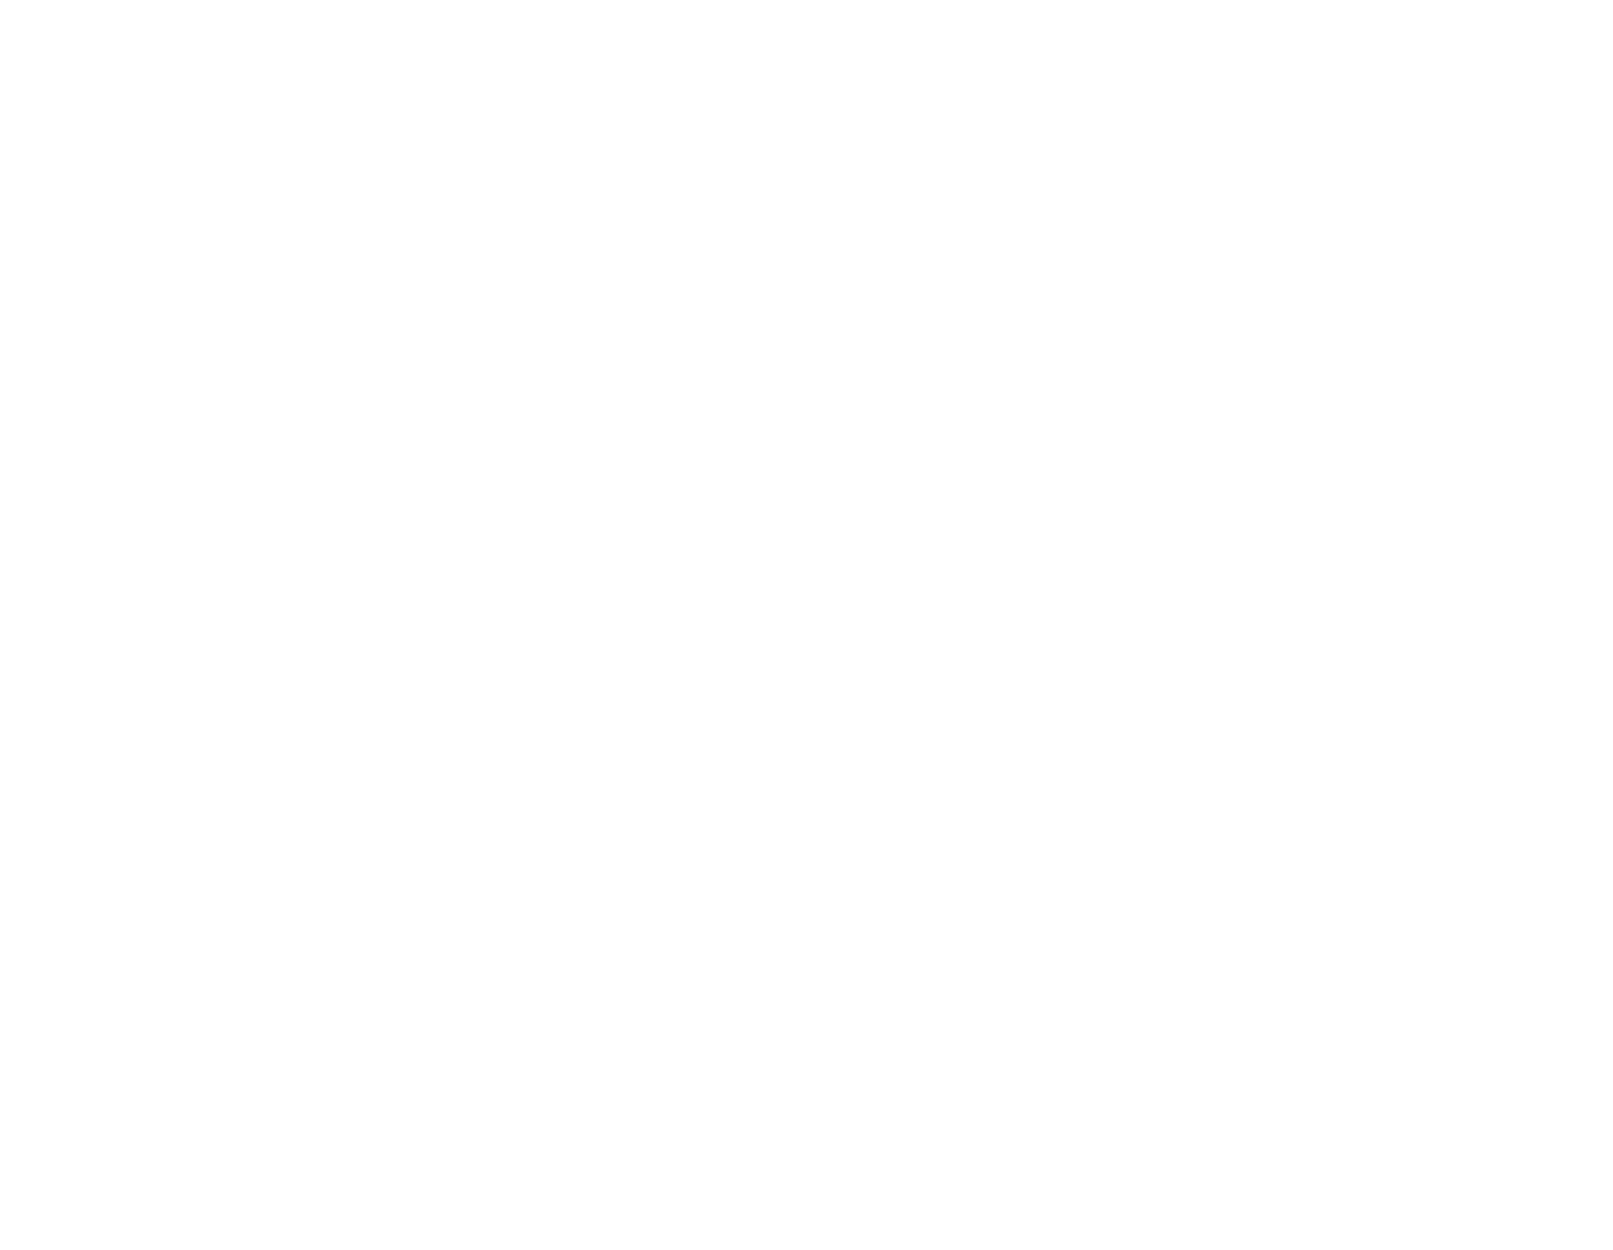

using device: cuda


RuntimeError: CUDA error: unknown error

In [26]:
# %matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))


def train_weights(x_train, N_hid, N_batch, Nep=Nep, mu=0, sigma=1, device="cpu"):
    # move train data to cuda
    N_train, N_in = x_train.shape
    x_train = attach(x_train)
    synapses = (torch.randn(N_hid, N_in) * sigma + mu).to(device)
    eps0 = torch.tensor(4e-2).to(device)

    for nep in range(Nep):
        eps=eps0*(1-nep/Nep)

        for i in range(N_train//N_batch):
            inputs=x_train[i*N_batch:(i+1)*N_batch,:] # v_i 
            ds, nc = forward(inputs, synapses, p, N_hid, N_batch)
            
            if nc < prec:
                nc = prec
            synapses += torch.mul(torch.div(ds, nc), eps)
        
        if (nep % 5) == 0:
            print('epoch ', nep)    
#         draw_weights(synapses.cpu().detach().numpy(), Kx, Ky)
    
    return synapses
        
print('using device: {}'.format(device))
start = time.time()
synapses = train_weights(x_train, N_hid, N_batch, Nep, device=device).to(device)
print('took {:.4f}s to run {} epochs'.format(time.time() - start, Nep))

## Saving or loading synapses
- If you want to save your own synapses from previous cell, uncomment and edit the first line
- If you want to load a pre-trained model, use the `np.load` function in the second line

A sample `synapses.npy` file can be found [here](https://drive.google.com/file/d/1ZEHI4yCa8ZqrwySM5_3jy-bcIenlUuA4/view?usp=sharing)


In [32]:
# save your own model
# np.save('synapses_hid{}_epoch{}_eps{}_p2_k2_batch100.npy'.format(N_hid, Nep, eps0), synapses.cpu().detach().numpy())
# np.save('synapses_hid100_epoch150_eps4e-2_p2_k2_batch100.npy', synapses)

# load a pre-trained model
synapses = np.load('synapses_hid1000_epoch2000_eps4e-2_p2_k2_batch100.npy')
# synapses = np.load('synapses_hid100_epoch150_eps4e-2_p2_k2_batch100.npy')


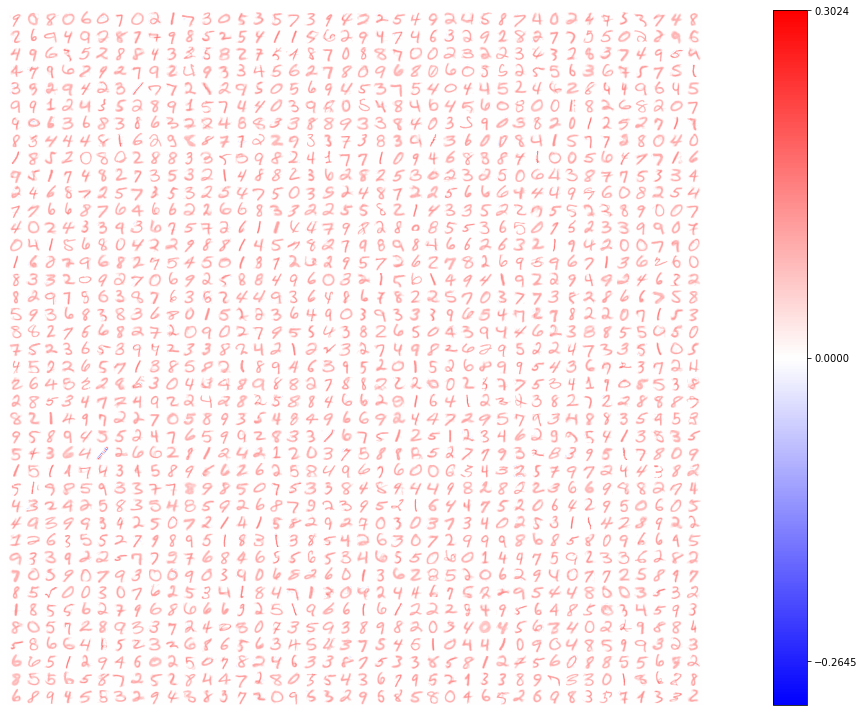

<Figure size 432x288 with 0 Axes>

In [42]:
%matplotlib inline
synapses = detach(synapses)
fig=plt.figure(figsize=(20, 10))
draw_weights(synapses, Kx*4, Ky*4)
# draw_weights(synapses, Kx, Ky)
plt.tight_layout()
plt.show()
plt.savefig('all_weights_Nhid{}.pdf'.format(N_hid))

### Looking at the weights
Weights seem to be mostly positive. Let's see if that's the case numerically!

In [43]:
synapses.min()
syn_list = synapses.ravel()
# nonzero_syn = np.array([g for g in syn_list if g != 0]) 
# np.median(gg)
syn_count = np.prod(synapses.shape)
print('Number of weights:', syn_count)
nonzero_count = np.count_nonzero(synapses)
print('Number of zero weights:', syn_count-nonzero_count)
nonzero_proportion = nonzero_count/syn_count
print('Proportion of zero weights', nonzero_proportion.round(2))
negative_count = np.count_nonzero(synapses<0)
print('Negative weights count:', negative_count)
positive_count = np.count_nonzero(synapses>0)
print('Positive weights count:', positive_count)

Number of weights: 1568000
Number of zero weights: 336208
Proportion of zero weights 0.79
Negative weights count: 536162
Positive weights count: 695630


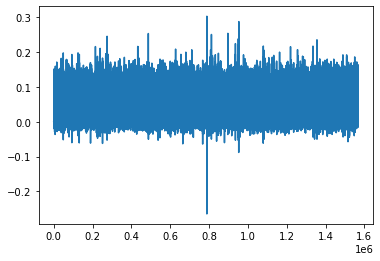

In [44]:
%matplotlib inline
plt.plot(syn_list)
plt.show()

### Let's look at the weights distribution 

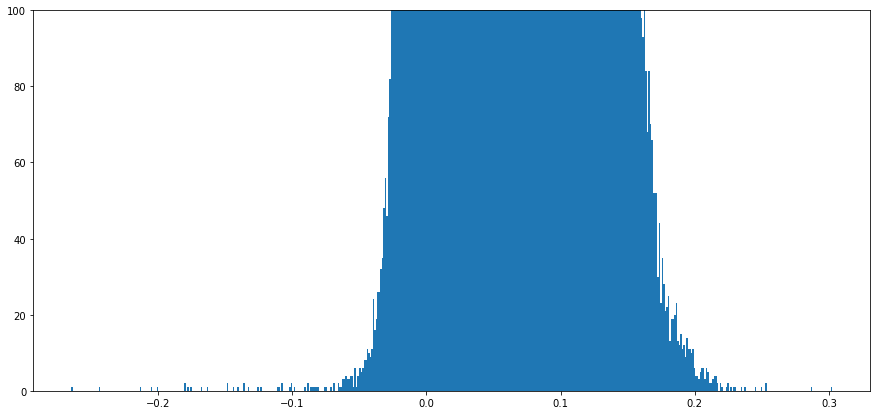

In [45]:
%matplotlib inline



plt.figure(figsize=(15,7))
plt.ylim(0, 100)
plt.hist(np.delete(synapses, 0).ravel(), bins=500)
plt.show()

In [47]:
def normalize(x):
    x_norm = x - np.mean(x, axis=1, keepdims=True)
    x_norm = x_norm / np.linalg.norm(x_norm, ord=2, axis=1, keepdims=True)
    return torch.from_numpy(x_norm).float().to(device)

## Testing: compute hidden neurons for train, val, and test data
This will be the input to the second layer, which will be trained with SGD to do digit recognition.

In [50]:
# Center and normalize input data to unit vectors  
synapses = attach(synapses)
x_train0 = normalize(x_train)
x_val0 = normalize(x_val)
x_test0 = normalize(x_test)
print(x_train0.shape)

x_hid_train = forward(x_train0, synapses, p, N_hid, N_train, training=False)
x_hid_val = forward(x_val0, synapses, p, N_hid, N_val, training=False)
x_hid_test = forward(x_test0, synapses, p, N_hid, N_test, training=False)

n=4.5
x_hid_train = (x_hid_train * (x_hid_train>0)) ** n
x_hid_val = (x_hid_val * (x_hid_val>0)) ** n
x_hid_test = (x_hid_test * (x_hid_test>0)) ** n


RuntimeError: CUDA error: unknown error

In [49]:
# convert everything to numpy tensors
x_hid_train_tf = detach(x_hid_train)
x_hid_val_tf = detach(x_hid_val)
x_hid_test_tf = detach(x_hid_test)

NameError: name 'x_hid_train' is not defined

## Define the BIO model
- Input is the pre-computed hidden activations.
- Output layer is a fully connected layer with softmax activation
- Loss function is the categorical cross-entropy
- Optimizer is Adam with initial learning rate of 0.1 which decays exponentially every 20 epochs with a decay rate of 0.7
- Batch size is 100 and number of epochs is 100

Set `verbose=1` in the `model.fit()` function to see the loss and accuracy values after each epoch.

In [ ]:
bio_model = keras.Sequential([
    tf.keras.layers.Input(shape=(N_hid,)),
    layers.Dense(Nc),
#     layers.BatchNormalization(),
    layers.Activation('softmax')
])

print(bio_model.summary())

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-1, decay_steps=Nep*20, decay_rate=0.7, staircase=True)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

bio_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
bio_logs = bio_model.fit(x_hid_train_tf, y_train, validation_data=(x_hid_test_tf, y_test), batch_size=100, epochs=100, verbose=1)

## Define the backprop model
- One fully-connected hidden layer with the same number of neurons as the BIO model, i.e. `N_hid`
    - Activation is 'relu'
- Another fully-connected output layer with softmax activation
- Same loss and optimizer as BIO

In [ ]:
bp_model = keras.Sequential([
    layers.Input(shape=(N_in,)),
    layers.Dense(N_hid),
#     layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dense(Nc, activation="softmax")
])
bp_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bp_logs = bp_model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=1000, epochs=20, verbose=1)

## Plot losses and accuracies

<IPython.core.display.Javascript object>


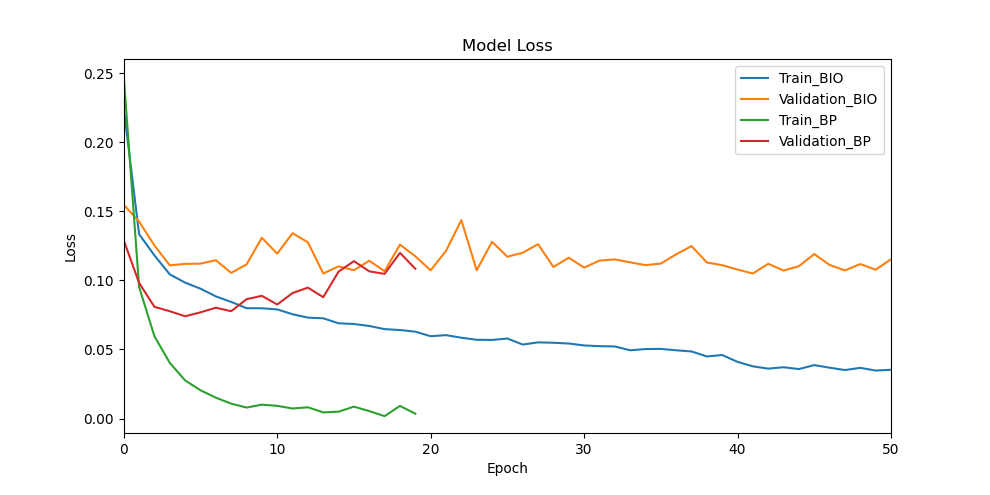

<IPython.core.display.Javascript object>


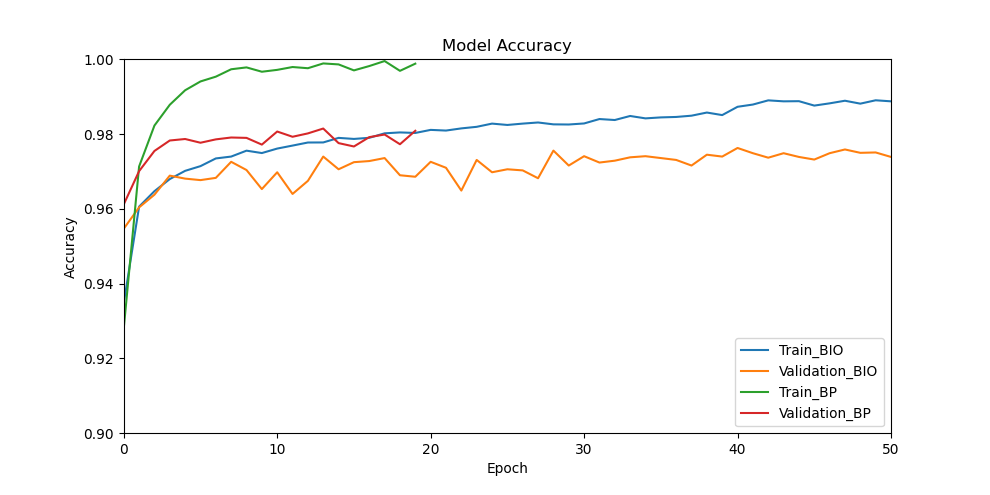

In [16]:
bio_history = bio_logs.history
bp_history = bp_logs.history

plt.figure(figsize=(10, 5))
plt.plot(bio_history['loss'])
plt.plot(bio_history['val_loss'])

plt.plot(bp_history['loss'])
plt.plot(bp_history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.ylim(0, 1)
plt.xlim(0, 50)
plt.legend(['Train_BIO', 'Validation_BIO', 'Train_BP', 'Validation_BP'], loc='upper right')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(bio_history['accuracy'])
plt.plot(bio_history['val_accuracy'])

plt.plot(bp_history['accuracy'])
plt.plot(bp_history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(.9, 1)
plt.xlim(0, 50)
plt.legend(['Train_BIO', 'Validation_BIO', 'Train_BP', 'Validation_BP'], loc='lower right')
plt.show()

In [17]:
print('BIO best validation accuracy:', max(bio_history['val_accuracy']))
print('BP best validation accuracy:', max(bp_history['val_accuracy']))

BIO best validation accuracy: 0.9771000146865845
BP best validation accuracy: 0.9815000295639038


## Plot weights of the BP model

<IPython.core.display.Javascript object>


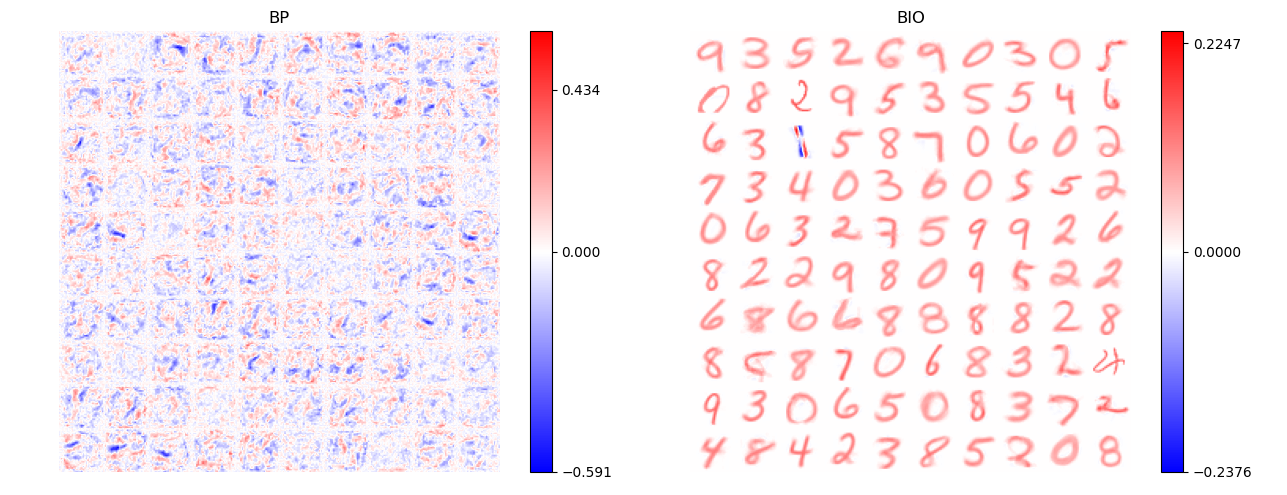

In [18]:
%matplotlib inline
%matplotlib notebook

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax[0].set_title('BP')
ax[1].set_title('BIO')
bp_weights = bp_model.layers[0].get_weights()[0].T
draw_weights(bp_weights, Kx, Ky, ax[0])
draw_weights(synapses, Kx, Ky, ax[1])
plt.tight_layout()
plt.show()

### Control Test: A model with only one output layer
If a model with only one output layer performs on paar with BIO, this means the images themselves are as representative as the biological hidden neurons.

In [19]:
control_model = keras.Sequential([
    layers.Input(shape=(N_in)),
    layers.BatchNormalization(),
    layers.Dense(Nc, activation='softmax')
])
control_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
control_logs = control_model.fit(x_train0, y_train, validation_data=(x_val0, y_val), batch_size=1000, epochs=100, verbose=1)

Epoch 1/100
50/50 [==============================] - 1s 12ms/step - loss: 2.8590 - accuracy: 0.8220 - val_loss: 10.8256 - val_accuracy: 0.0998
Epoch 2/100
50/50 [==============================] - 0s 9ms/step - loss: 0.6860 - accuracy: 0.8831 - val_loss: 5.0127 - val_accuracy: 0.1629
Epoch 3/100
50/50 [==============================] - 0s 9ms/step - loss: 0.4497 - accuracy: 0.8957 - val_loss: 4.0930 - val_accuracy: 0.0993
Epoch 4/100
50/50 [==============================] - 0s 9ms/step - loss: 0.3816 - accuracy: 0.9020 - val_loss: 3.3033 - val_accuracy: 0.2043
Epoch 5/100
50/50 [==============================] - 0s 10ms/step - loss: 0.3319 - accuracy: 0.9092 - val_loss: 2.6876 - val_accuracy: 0.2861
Epoch 6/100
50/50 [==============================] - 0s 9ms/step - loss: 0.3028 - accuracy: 0.9170 - val_loss: 2.1134 - val_accuracy: 0.3864
Epoch 7/100
50/50 [==============================] - 1s 11ms/step - loss: 0.2989 - accuracy: 0.9159 - val_loss: 1.6516 - val_accuracy: 0.4206
Epoch 8/1

Epoch 59/100
50/50 [==============================] - 0s 9ms/step - loss: 0.2895 - accuracy: 0.9178 - val_loss: 0.3254 - val_accuracy: 0.9144
Epoch 60/100
50/50 [==============================] - 0s 9ms/step - loss: 0.2875 - accuracy: 0.9177 - val_loss: 0.3255 - val_accuracy: 0.9145
Epoch 61/100
50/50 [==============================] - 0s 8ms/step - loss: 0.2901 - accuracy: 0.9163 - val_loss: 0.3113 - val_accuracy: 0.9185
Epoch 62/100
50/50 [==============================] - 0s 9ms/step - loss: 0.2821 - accuracy: 0.9194 - val_loss: 0.3218 - val_accuracy: 0.9149
Epoch 63/100
50/50 [==============================] - 0s 8ms/step - loss: 0.2896 - accuracy: 0.9173 - val_loss: 0.3242 - val_accuracy: 0.9129
Epoch 64/100
50/50 [==============================] - 0s 8ms/step - loss: 0.2817 - accuracy: 0.9189 - val_loss: 0.3277 - val_accuracy: 0.9148
Epoch 65/100
50/50 [==============================] - 0s 8ms/step - loss: 0.2833 - accuracy: 0.9192 - val_loss: 0.3086 - val_accuracy: 0.9195
Epoch 

In [20]:
print("Final Training Accuracy:", control_logs.history['accuracy'][-1])
print("Final Validation Accuracy:", control_logs.history['val_accuracy'][-1])

Final Training Accuracy: 0.9209399819374084
Final Validation Accuracy: 0.9178000092506409


## Train a second hidden layer
The goal is to have two hidden layers, each having 100 neurons.

In [28]:
def forward(inputs, synapses, p, N_hid, N_batch, training=True):
    inputs = np.transpose(inputs)
    sig=np.sign(synapses)
    tot_input=np.dot(sig*np.absolute(synapses)**(p-1),inputs) # with p=2, this is equal to <W.v> = I 
    

    if training == False:
        return tot_input.T
    
    # TODO: compute h...
    
    y=np.argsort(tot_input,axis=0) # using tot_input (I) as proxy for h
    yl=np.zeros((N_hid, N_batch)) # y1 = g(Q)
    yl[y[N_hid-1],np.arange(N_batch)]=1.0 # g(max_activation in I) = 1
    yl[y[N_hid-k],np.arange(N_batch)]=-delta # g(second max activation) = -0.4
#     if training == False:
#         return yl.T
    xx=np.sum(np.multiply(yl,tot_input),1) # g(Q) x <W, v>
#     print(inputs.shape)
#     print(np.dot(yl, np.transpose(inputs)).shape)
#     print(np.tile(xx.reshape(xx.shape[0],1),(1,N_in)).shape)
#     print(np.multiply(np.tile(xx.reshape(xx.shape[0],1),(1,N_in)),synapses).shape)
    ds=np.dot(yl,np.transpose(inputs)) - np.multiply(np.tile(xx.reshape(xx.shape[0],1),(1,N_hid)),synapses)
    # g(Q) (v_i - <W,v> W_i)
    nc=np.amax(np.absolute(ds))
    return ds, nc

<IPython.core.display.Javascript object>


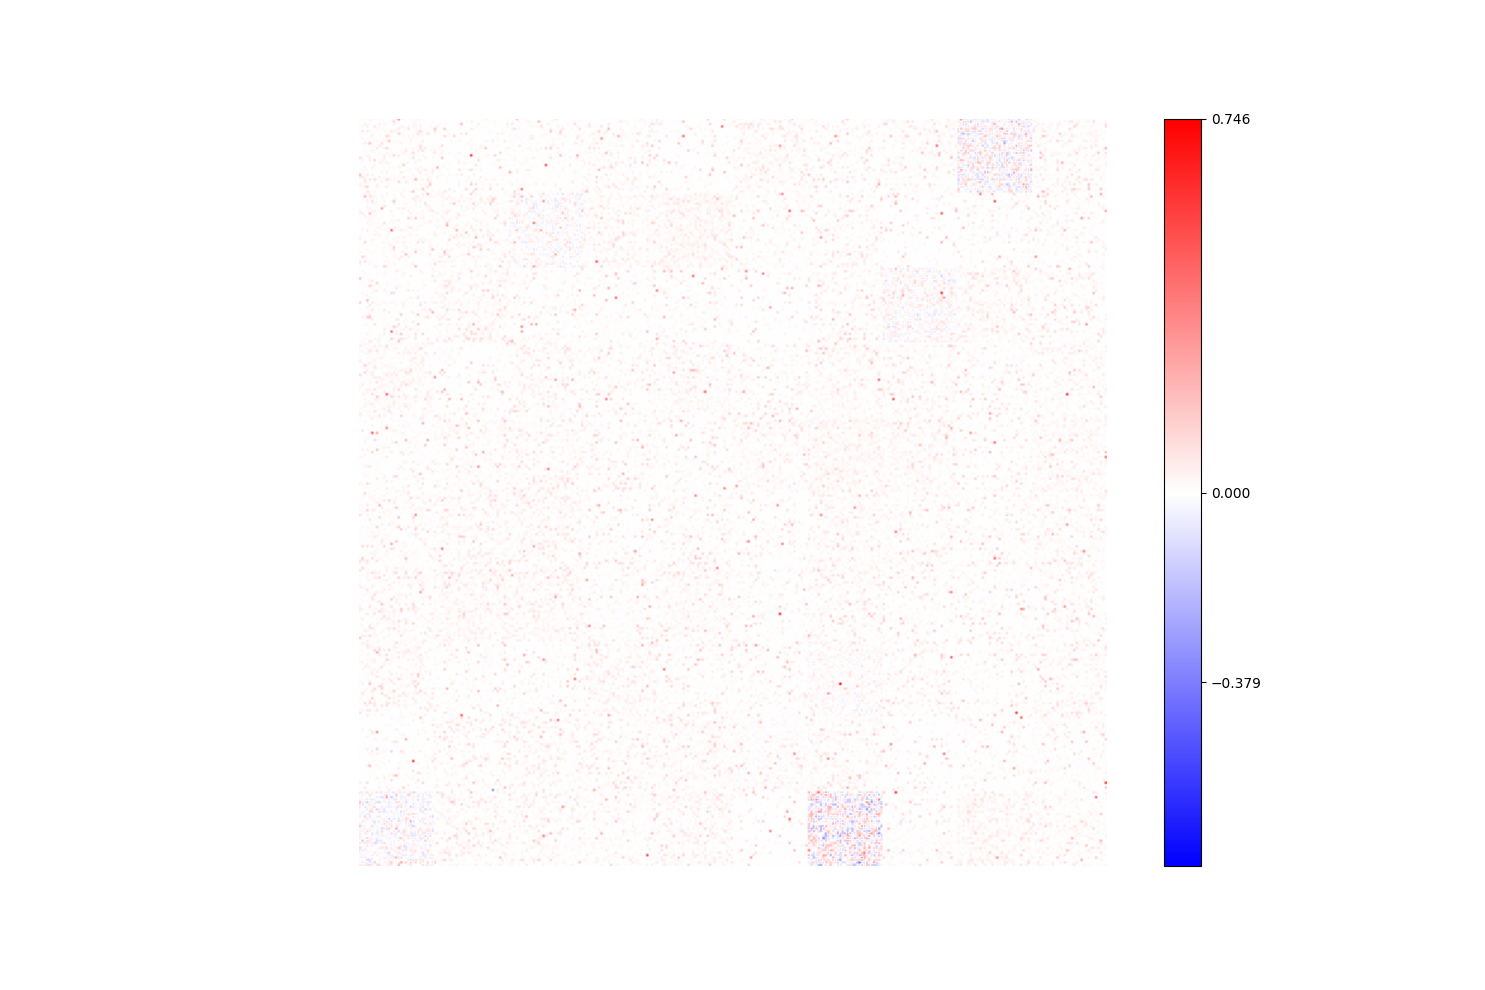

(1000, 1000)
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49


In [34]:
%matplotlib inline
%matplotlib notebook
eps0 = 2e-2
fig = plt.figure(figsize=(15,10))
plt.tight_layout()
# print(x_hid_train.shape)
synapses_2 = train_weights(x_hid_train, N_hid, N_batch=N_batch, Nep=50)

In [35]:
# Center and normalize input data to unit vectors  
x_train1 = normalize(x_hid_train)
x_val1 = normalize(x_hid_val)
x_test1 = normalize(x_hid_test)

x_hid_train2 = forward(x_train1, synapses_2, p, N_train, training=False)
x_hid_val2 = forward(x_val1, synapses_2, p, N_val, training=False)
x_hid_test2 = forward(x_test1, synapses_2, p, N_val, training=False)

n=2
x_hid_train2 = (x_hid_train2 * (x_hid_train2>0)) ** n
x_hid_val2 = (x_hid_val2 * (x_hid_val2>0)) ** n

In [36]:
bio_model2 = keras.Sequential([
    layers.Input(shape=(N_hid,)),
    layers.Dense(Nc),
    layers.BatchNormalization(),
    layers.Activation('softmax')
])
print(bio_model2.summary())
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-1, decay_steps=Nep*20, decay_rate=0.7, staircase=True)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
bio_model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
bio_logs2 = bio_model2.fit(x_hid_train2, y_train, validation_data=(x_hid_val2, y_val), batch_size=100, epochs=100, verbose=1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 10)                10010     
_________________________________________________________________
batch_normalization_1 (Batch (None, 10)                40        
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 10,050
Trainable params: 10,030
Non-trainable params: 20
_________________________________________________________________
None
Epoch 1/100
500/500 [==============================] - 2s 2ms/step - loss: 0.3200 - accuracy: 0.9033 - val_loss: 0.2038 - val_accuracy: 0.9401
Epoch 2/100
500/500 [==============================] - 1s 2ms/step - loss: 0.1874 - accuracy: 0.9443 - val_loss: 0.1756 - val_accuracy: 0.9496
Epoch 3/100
500/500 [==============================] - 1s 2ms/step - loss: 0.1728 - accu

Epoch 53/100
500/500 [==============================] - 1s 1ms/step - loss: 0.1701 - accuracy: 0.9486 - val_loss: 0.1709 - val_accuracy: 0.9502
Epoch 54/100
500/500 [==============================] - 1s 1ms/step - loss: 0.1691 - accuracy: 0.9498 - val_loss: 0.1713 - val_accuracy: 0.9504
Epoch 55/100
500/500 [==============================] - 1s 1ms/step - loss: 0.1718 - accuracy: 0.9491 - val_loss: 0.1710 - val_accuracy: 0.9503
Epoch 56/100
500/500 [==============================] - 1s 1ms/step - loss: 0.1700 - accuracy: 0.9490 - val_loss: 0.1708 - val_accuracy: 0.9501
Epoch 57/100
500/500 [==============================] - 1s 1ms/step - loss: 0.1702 - accuracy: 0.9486 - val_loss: 0.1710 - val_accuracy: 0.9504
Epoch 58/100
500/500 [==============================] - 1s 1ms/step - loss: 0.1701 - accuracy: 0.9487 - val_loss: 0.1709 - val_accuracy: 0.9501
Epoch 59/100
500/500 [==============================] - 1s 1ms/step - loss: 0.1704 - accuracy: 0.9486 - val_loss: 0.1709 - val_accuracy:

<IPython.core.display.Javascript object>


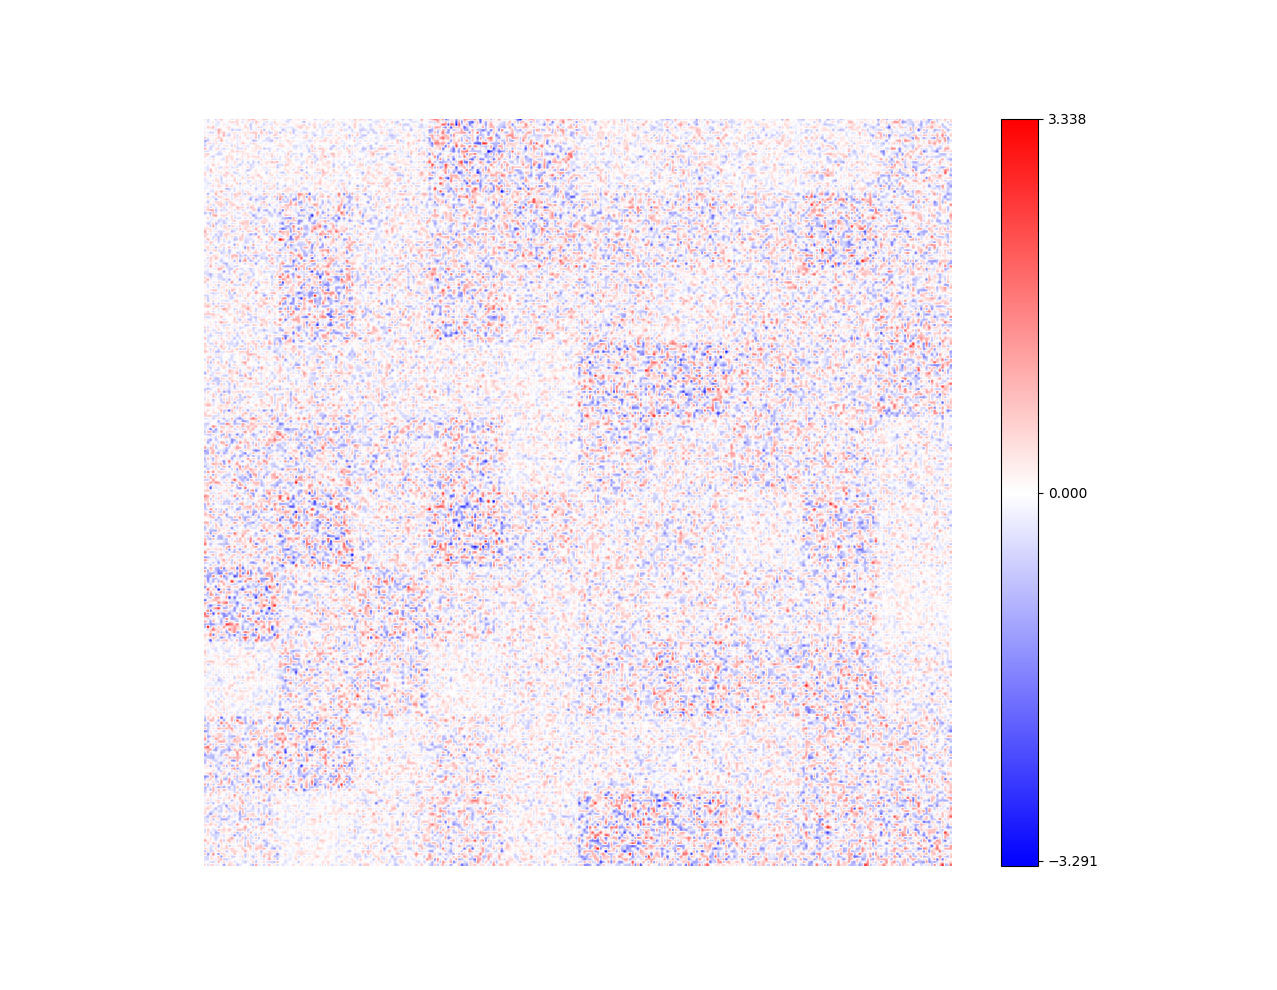

using device: cuda
epoch  0
epoch  2
epoch  4
epoch  6
epoch  8
took 63.0274s to run 5 epochs


## Next steps
**Update 19.12.2021**: We couldn't reproduce the paper results with 100 hidden neurons. We noticed that the paper uses 2000 hidden neurons, so we used a hidden layer of size 1000 (since 2000 would take too much time). This took about 12 hours to train on my local machine (Intel Core-i7-4702MQ, 16GB RAM). This is pretty much impractical and incomparable with the training of the BP-based model in terms of efficiency. One idea is to see if two hidden layers of lower size will increase accuracy while lowering the training time.  

### short-term 
- ~~load data from keras (MNIST)~~
- ~~add a softmax layer to train the netwok (SGD, ...)~~
- ~~get the network run on a simple validation set~~
- ~~get the accuracy ...~~
- fine-tune bio model to get the best result
- ~~add a second hidden layer~~
- ~~visualize all hidden neurons~~
- ~~distrtibution of the weights~~
- check the range of the weights (they're currently not consistent w the paper) 
- clean the notebooks
- merge the gpu code inside the notebooks. 
- merging our git branches
- make a backup from our local repositories. 

### long-term
- ~~get the result from the bio network~~
- ~~train a "usual" net~~
- ~~compare the results~~
- ~~visualize the weights in the backprop-based network~~
- do the bio computation on gpu?
- ~~do the unsupervised part on a _faces_ dataset (alternative: fashion-mnist)~~
 

### challenge
- BP model converges with far fewer hidden neurons (let's find out the minimum number of hidden neurons in BP where it still outperforms BIO model).
- Currently our BIO model is not performing on the same level as reported in the paper.